# Assignment 2, Question 1: Self-tuning robots

* TEAM NUMBER = 2
<br>

* TEAM MEMBER 1 = Naomi Moonen (mainly contributed towards A2Q1)
* TEAM MEMBER 2 = Nick Sieraad (mainly contributed towards A2Q2)
* TEAM MEMBER 3 = Vincie Vossenaar (mainly contributed towards A2Q2)
* TEAM MEMBER 4 = Kevin Reijnders (mainly contributed towards A2Q1)

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
import random
import math

In [2]:
#Remove comment from line below to show figures correctly in JupyterLab.
#set_matplotlib_formats("svg")

## Robot Navigation
The [Wall robot navigation](https://www.openml.org/d/1497) contains training data for a robot equiped with ultrasound sensors. Based on 24 sensor readings, the robot has to figure out how to move though an office space without hitting walls or other obstacles. In this assignment, the robot uses an SVM to learn how to do this. 

However, instead of building a static model, we want to robot to tune the hyperparameters of its SVM model regularly. This will make it more robust to changes, for instance a breaking sensor. Since the robot is very busy, this regular re-training should take as little time as possible. Your assignment is to implement a fast tuning algorithm that optimizes the hyperparameter configurations faster and better than a random search or grid search.

## The data
The data is visualized below. It contains traces of training runs of the robot. In the figure below, we plot the first two sensor readings, color-coded by the correct action to take (move forward, left or right). You can handle these data points as independently sampled, i.e. you never need to look at the 'previous' data point.

In [3]:
# Download Wall Robot Navigation data from OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, attribute_names = robot.get_data(target=robot.default_target_attribute, return_attribute_names=True);
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

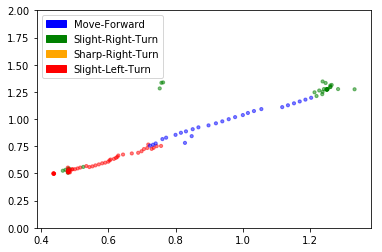

In [4]:
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # First 120 points
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

## Multi-fidelity optimization
We will implement a fast optimization technique generally known as _multi-fidelity optimization_. Instead of training the model on all the training data for every hyperparameter configuration, we use the following procedure:

Successive Halving (only look at the top left image):
- collect $n$ random hyperparameter configurations (squares in the image below)
- split the original training data randomly in half, and repeat this $k$ times
- evaluate all hyperparameter configurations on the smallest sample
- select the best 50% of configurations (green squares), and run these on the next larger sample
- repeat until all training data has been used, and return the best of the remaining configuration (white squares)

Obviously, this can lead to suboptimal results, since you may remove a configuration too soon: it may be worse on a small sample but better on a larger sample, i.e. its learning curve may cross and overtake others. A simple solution for this is called [_Hyperband_](https://arxiv.org/pdf/1603.06560.pdf), illustrated below.

Hyperband:
- Do one successive halving run (also called a _bracket_)
- Start a new bracket with an initial sample twice as large, but with only log_3(n) configurations.
- Repeat until you have done this for all subsamples. Return the best overall method.

![Hyperband](hyperband.png)

In [5]:
# Helper code
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: flattened array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Questions

1_ Landscape analysis: visualize the configuration search space (2 points)

- Do a grid search for an SVM with the RBF kernel. Vary both the C and $\gamma$ at the same time, on a log scale from $2^{-15}$ to $2^{15}$. Use at least 20 values for each, unless you are limited by computational resources.
    - Hint: Start with a small grid and see how long that takes. If this is fast, you can use a finer grid.
- Visualize the results in a plot $C \times \gamma \rightarrow \rho$ with $\rho$ being the performance of the model (Accuracy) visualized as the color of the data point. 
    - You can use the code above for this.
- Interpret and explain the result. Is there a single optimum? Is the landscape smooth? Does this make sense given what you know about SVMs and the role of the $C$ and $\gamma$ parameter?

Unfortunately, the PDF of our assignment exceeds the page limit, but the high amount of pages can mainly be attributed to the printing of several large heatmaps (which enhance readability), some repetition of code and empty (or nearly empty) pages. We therefore find the length of our assignment is still appropriate, regardless of the page count.

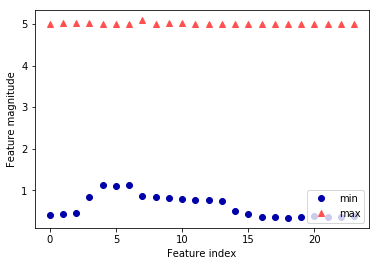

In [6]:
#Support vector machines are very sensitive to the scaling of data. Therefore we first examine the scales of the features.
df_robot = pd.DataFrame(X);
df_robot['y']=y;
plt.plot(X.min(axis=0), 'o', label="min");
plt.plot(X.max(axis=0), '^', label="max");
plt.legend(loc=4);
plt.xlabel("Feature index");
plt.ylabel("Feature magnitude");

From this plot it seems like the scales for all 24 features are similar. Hence no scaling is needed.

**Grid Search SVM with RBF Kernel**

In [7]:
param_grid = {'C': np.logspace(-15, 15, base=2, num=20), 'gamma': np.logspace(-15, 15, base=2, num=20)};
grid = GridSearchCV(SVC(kernel='rbf', random_state=0), param_grid=param_grid, cv=3, n_jobs=-1);
grid.fit(X, y);

**Visualization of results**

In [8]:
plt.rcParams["figure.figsize"] = (20, 12);

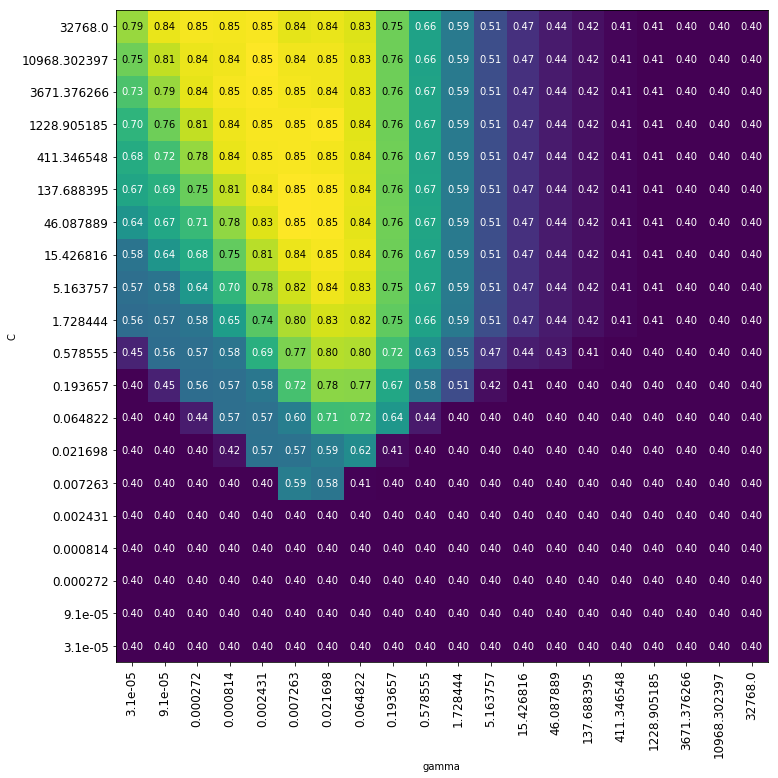

In [9]:
values = np.ndarray.flatten(grid.cv_results_['mean_test_score']).reshape(20,20)
heatmap(values=values, ylabel='C', xlabel='gamma', yticklabels=param_grid['C'].round(6),\
        xticklabels=param_grid['gamma'].round(6),fmt="%0.2f", printvalues=True);

In [10]:
#Print best result
print(grid.best_params_)
print(grid.best_score_)

{'C': 137.6883950361833, 'gamma': 0.007262776211003177}
0.8546554252199413


It seems that parameters with gamma=0.007262776211003177 and C=137.6883950361833 provide the best test-score performance (0.85). However, other combinations of parameters also have an accuarcy of 0.85, as the heatmap shows. For example, when gamma=0.0072 and 46.08<=C<=3671.37 accuracies are all 0.85. Therefore, it does not seem like there is a single optimum in this grid-search. In general, gamma is relatively small and C relatively high for good performances on this data. The landscape of the map is relatively smooth: the valley is at the bottom half and right half of the grid; the accuracies improve towards the left with the highest accuracies to the left of the middle; on the left side, the accuracies decrease a bit again. The small gamma means that it is optimal to have a relatively wide gaussian and each training instance has a far influence. Hence, the Gaussian function has a large variance and training points that are actually far from each other, are still considered as similar. Thus, a small gamma value defines a Gaussian function with a large variance.The large C means that it is optimal to have a moderate to high influence of individual support vectors. The C parameter has a regularization function in the SVM. The large C means that the decision function's margin is small and classifies many training examples correctly. Given that the data is probably quite complex, these parameters thus make sense from an intuitive viewpoint.  

2_ Implement Successive Halving (3 points)
* Implementing a function that performs a single step as described above
    - Input: data sample, list of input configurations
    - Output: list of selected configurations
    - Print a trace of the best configuration and its accuracy after every step
* Implement the outer loop
    - Input: the complete dataset and list of random configurations
    - Output: the best final configuration and model
* Run the whole procedure using $n=100$ and $k=5$
* Discuss the results. Is this faster/better than a normal grid or random search? Do you still get an improvement in the later runs?

As described on the blackboard thread, we will assume that $k=5$ means that that we split the data 4 times (i.e. we then have 5 samples and evaluate 6 configurations in the final halving step).

In [11]:
#Function that performs single step of successive halving
def SH_step(X, y, inputConfigs):
    """
    Input:
    X: predictors of the sample
    y: the target labels of the sample
    inputConfigs: a nested array containing the parameter configurations, such as for instance [[1,2], [1,4], [1,3]]. 
    In every pair, we assume the first parameter is C and the second is gamma.
    
    Output:
    List of selected configurations
    """
    configScores = [] #initialize array with scores
    configs = inputConfigs #store configurations locally
    
    #compute and store scores for all configurations
    for i in range(len(configs)):
        configScores.append(np.mean(cross_val_score(SVC(kernel='rbf', C=configs[i][0], \
                                    gamma=configs[i][1], random_state=0), X=X, y=y)))
    
    #Print best configuration and accuracy
    print("Best configuration:", "C, gamma =", configs[np.argmax(configScores)])
    print("Best accuracy:", np.max(configScores))
    
    #Return list of selected configurations (floor(n/2) configurations with best accuracies)
    numberOfSelectedConfigs = len(configs)//2
    selectedConfigs = []
    
    for i in range(numberOfSelectedConfigs): #Repeat for amount of configurations required
        bestConfigIndex=np.argmax(configScores)
        selectedConfigs.append(configs.pop(bestConfigIndex)) #Select best config & remove from configurations
        configScores.pop(bestConfigIndex); #Also remove selected config from the scores
    
    return selectedConfigs

In [12]:
#Setting the inputconfigurations
param_grid = {'C': np.logspace(-15, 15, base=2, num=20), 'gamma': np.logspace(-15, 15, base=2, num=20)}  
new_param_list_C=[]
new_param_list_gamma=[]
random.seed(1) #Random seed 1 for reproducibility
for i in range(100): #Generate n (=100) random configurations and store them in the lists. 
    new_param_list_C.append(random.choice(param_grid['C']))
    new_param_list_gamma.append(random.choice(param_grid['gamma']))
inputConfigs = list(zip(new_param_list_C,new_param_list_gamma)) #Zip lists to associate each C with a gamma

In [13]:
#Successive halving implement as a function (to eaze question 3 & 4)
def SuccessiveHalving(X, y, inputConfigs, k):
    """
    Input:
    X: predictors of the observations
    y: the target labels of the observations
    inputConfigs: a nested array containing the initial parameter configurations, such as for instance [[1,2], [1,4], [1,3]]. 
    In every pair, we assume the first parameter is C and the second is gamma.
    k: the number of different sample sizes for this run (i.e. k=amount of times the data is halved + 1)
    
    Output:
    Best final configuration and best final model (and some printing of relevant results)
    """
    
    #Store input configurations locally
    configs_local = inputConfigs
    
    #Perform the halving of the data
    X_samples = [X]
    y_samples = [y]

    for i in range(k-1): #when k=5, split the data 4 times
        X_half1, X_half2, y_half1, y_half2 = train_test_split(X_samples[i],y_samples[i],test_size=0.5,random_state=0);
        X_samples.append(X_half1)
        y_samples.append(y_half1)
    
    #Reverse the samples so the smallest is in the first index and the biggest in the last
    X_samples.reverse()
    y_samples.reverse()
        
    #Run the successive halving steps
    for i in range(len(X_samples)-1): #Halve k-1 times
        print("Iteration:",i+1, "; Sample size:", len(X_samples[i]),\
              "; Number of selected configurations at start of iteration:", len(configs_local))
        print("")
        configs_local = SH_step(X_samples[i],y_samples[i],configs_local)
        print("")
        print("Number of selected configurations at end of iteration:", len(configs_local))
        print("")
    
    #Now find the best configuration of those which are left
    configs_local_scores = np.array([])
    
    for config in configs_local:
        result = np.mean(cross_val_score(SVC(kernel='rbf', C=config[0], \
                                    gamma=config[1], random_state=0), X=X_samples[k-1], y=y_samples[k-1]))
        configs_local_scores = np.append(configs_local_scores, result)
    
    index_best_config = configs_local_scores.argmax()
    
    print("Best final accuracy:",configs_local_scores.max())
    
    return configs_local[index_best_config], SVC(kernel='rbf', C=configs_local[index_best_config][0],\
                                                 gamma=configs_local[index_best_config][1], random_state=0)
    

In [14]:
#Now run the successive halving. Included some extra printing to show what happens during the iterations
SuccessiveHalving(X,y,inputConfigs,5)

Iteration: 1 ; Sample size: 341 ; Number of selected configurations at start of iteration: 100

Best configuration: C, gamma = (411.3465480022443, 0.0008137324281235784)
Best accuracy: 0.7150802976889933

Number of selected configurations at end of iteration: 50

Iteration: 2 ; Sample size: 682 ; Number of selected configurations at start of iteration: 50

Best configuration: C, gamma = (15.426815967079905, 0.021697674103353992)
Best accuracy: 0.7916905498433598

Number of selected configurations at end of iteration: 25

Iteration: 3 ; Sample size: 1364 ; Number of selected configurations at start of iteration: 25

Best configuration: C, gamma = (1228.9051848479778, 0.002431040213796921)
Best accuracy: 0.860695700337481

Number of selected configurations at end of iteration: 12

Iteration: 4 ; Sample size: 2728 ; Number of selected configurations at start of iteration: 12

Best configuration: C, gamma = (1228.9051848479778, 0.002431040213796921)
Best accuracy: 0.8911290030101912

Numbe

((46.087889201240316, 0.007262776211003177),
 SVC(C=46.087889201240316, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.007262776211003177,
   kernel='rbf', max_iter=-1, probability=False, random_state=0,
   shrinking=True, tol=0.001, verbose=False))

This approach is a lot faster than grid_search (this takes approximately 30 seconds, while the grid_search from 1. took about 20 minutes to run without parallelizing). This makes sense because in the grid search we performed way more model evaluations: in the grid search 400 configurations were evaluated, all on the full the data. In the successive halving runs we only evaluate 100+50+25+12+6=193 configuratoins, of which the vast majority is evaluated on a dataset with fewer observations than in the full dataset. In the successive halving steps, the accuracy of the best model first increases but then decreases in the final step. However, in the end, two (near) optimal hyperparameters are found. The value for gamma is similar to grid search, but the value for C is not. Still, the accuracy for these two parameters is also 0.85 if we round the accuracy down to two decimals. Hence, successive halving performs faster and results in a model with (nearly) the same accuracy as grid search.

3_ Visualize Successive Halving (2 points)
* For each step, generate a plot with the following:
    - The heatmap as produced in point 1. This requires a complete grid search on the subsample of the data in that step.
    - The selected random configurations superimposed (eg. use white dots/crosses)
* The answer should be a series of 5 of such plots
* Interpret and explain the result. Does it seem like the method is doing anything useful?

In [15]:
#Function that performs single step of successive halving without the printing
def SH_step_3(X, y, inputConfigs):
    """
    Input:
    X: predictors of the sample
    y: the target labels of the sample
    inputConfigs: a nested array containing the parameter configurations, such as for instance np.array([[1,2], [1,4], [1,3]]). 
    In every pair, we assume the first parameter is C and the second is gamma.
    
    Output:
    List of selected configurations
    """
    configScores = [] #initialize array with scores
    configs = inputConfigs #store configurations locally
    
    #compute and store scores for all configurations
    for i in range(len(configs)):
        configScores.append(np.mean(cross_val_score(SVC(kernel='rbf', C=configs[i][0], \
                                    gamma=configs[i][1], random_state=0), X=X, y=y)))
    
    #Return list of selected configurations (floor(n/2) configurations with best accuracies)
    numberOfSelectedConfigs = len(configs)//2
    selectedConfigs = []
    
    for i in range(numberOfSelectedConfigs): #Repeat for amount of configurations required
        bestConfigIndex=np.argmax(configScores)
        selectedConfigs.append( configs.pop(bestConfigIndex) ) #Select best config & remove from configurations
        configScores.pop(bestConfigIndex); #Also remove selected config from the scores
    
    return selectedConfigs

In [16]:
#Store the corresponding coordinates for superimposing the configurations
coord = {param_grid['C'][i]:i+0.5 for i in range(20)} 
#Note that we do not need to separate x (gamma) and y (C) because they have the same possible values

In [17]:
#Setting the inputconfigurations again
param_grid = {'C': np.logspace(-15, 15, base=2, num=20), 'gamma': np.logspace(-15, 15, base=2, num=20)}  
new_param_list_C=[]
new_param_list_gamma=[]
random.seed(1) #Random seed 1 for reproducibility
for i in range(100): #Generate n (=100) random configurations and store them in the lists. 
    new_param_list_C.append(random.choice(param_grid['C']))
    new_param_list_gamma.append(random.choice(param_grid['gamma']))
inputConfigs = list(zip(new_param_list_C,new_param_list_gamma)) #Zip lists to associate each C with a gamma

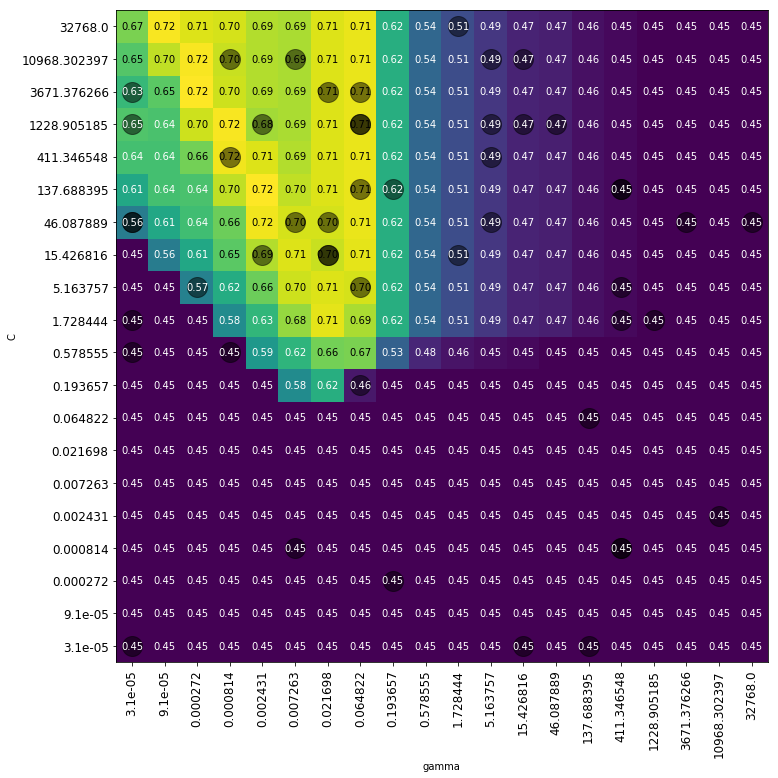

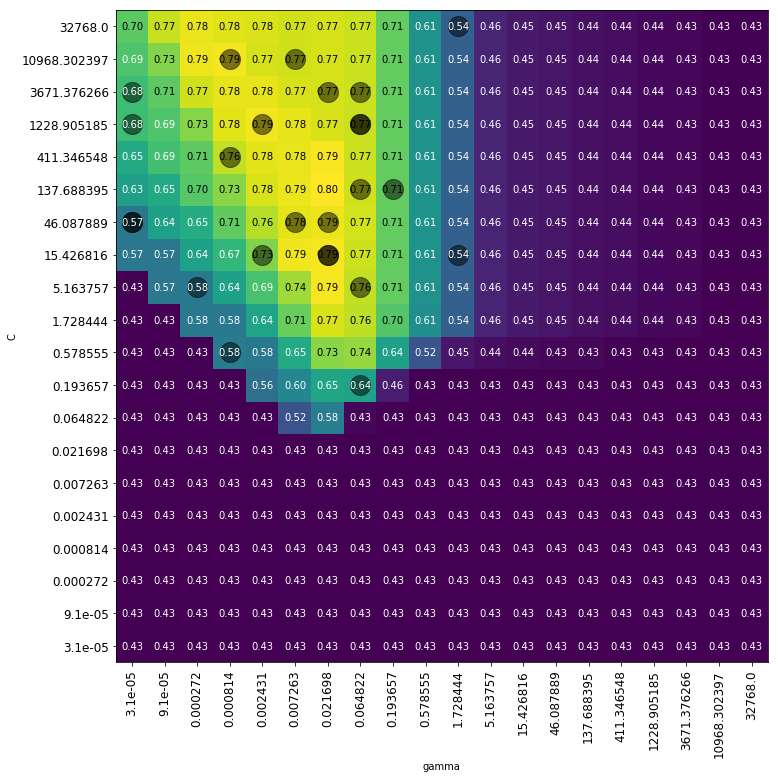

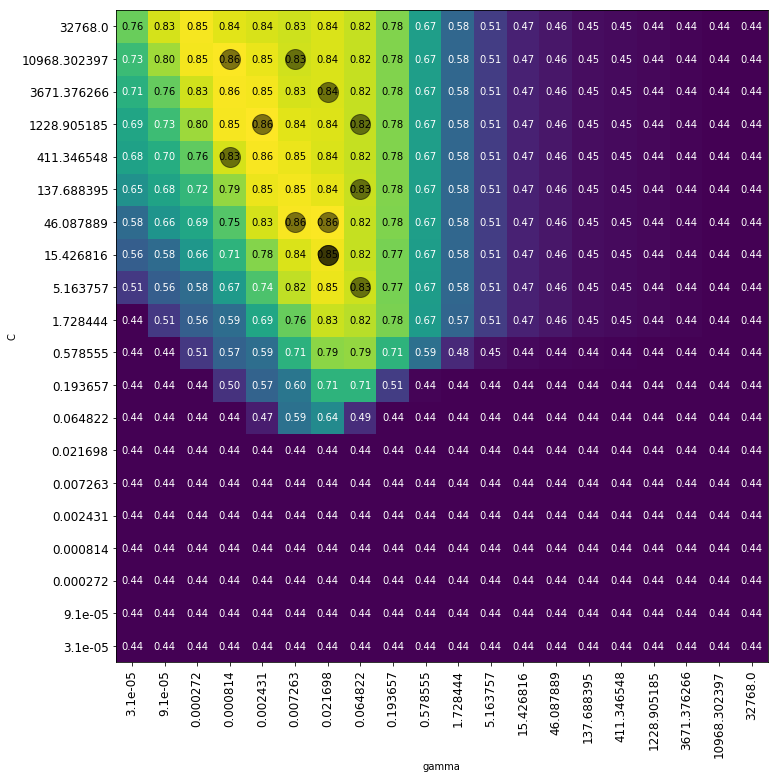

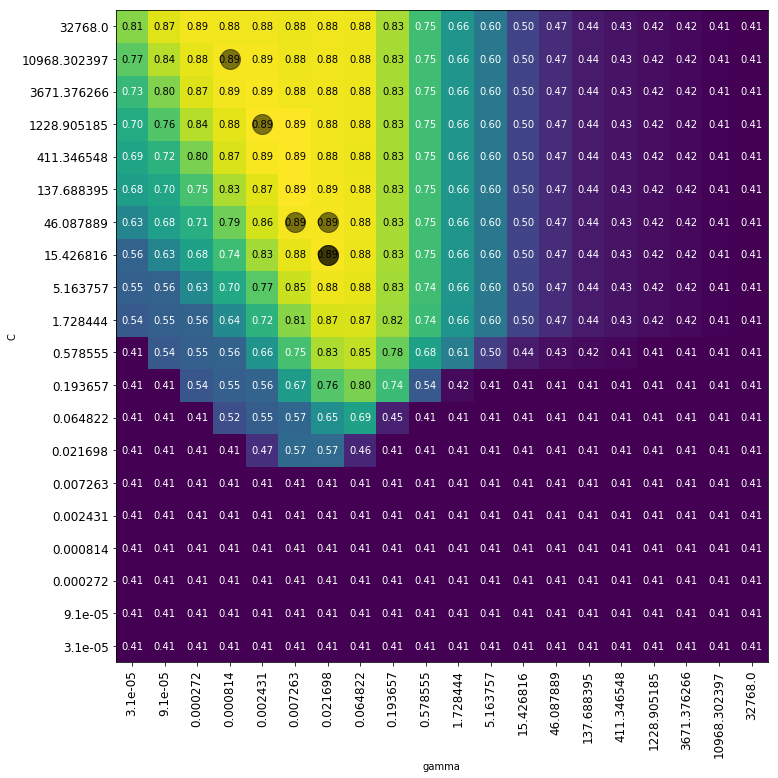

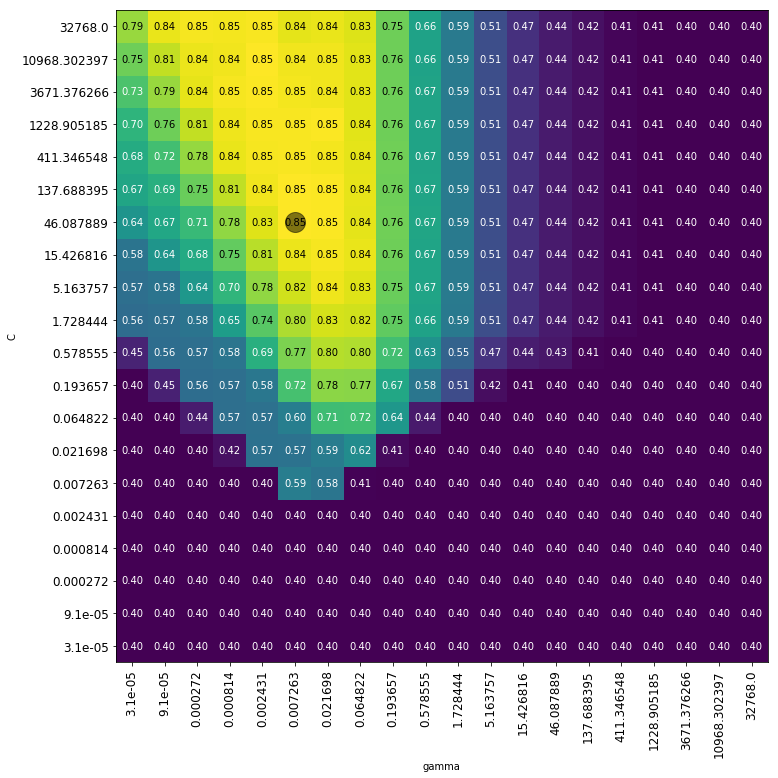

In [18]:
#Generating the heatmaps with markings
#Creating the splits
X_samples = [X]
y_samples = [y]

for j in range(4):
    X_half1, X_half2, y_half1, y_half2 = train_test_split(X_samples[j],y_samples[j],test_size=0.5,random_state=0);
    X_samples.append(X_half1)
    y_samples.append(y_half1)
    
#Reverse the samples so the smallest is in the first index and the biggest in the last
X_samples.reverse()
y_samples.reverse()
        
for i in range(5): #Iterate 5 times because we include the final evaluation (without halving step) in the loop
    
    #Initiating the plot
    fig,ax = plt.subplots(1,1)
    
    if(i!=4): #While not at the final step, perform the gridsearch
        #Performing the gridsearch and generating the heatmap like in 1
        grid3 = GridSearchCV(SVC(kernel='rbf', random_state=0), param_grid=param_grid, n_jobs=-1)
        grid3.fit(X_samples[i], y_samples[i]);
        values3 = np.ndarray.flatten(grid3.cv_results_['mean_test_score']).reshape(20,20)
        heatmap(values=values3, ylabel='C', xlabel='gamma', yticklabels=param_grid['C'].round(6),\
                xticklabels=param_grid['gamma'].round(6),fmt="%0.2f", printvalues=True, ax=ax)
    
        #Running the successive halving step and updating the inputConfigs
        #Some optional printing included as a check
        #print("Iteration:", 5-i, "; Sample size:",len(X_samples[i]))
        #print("Number of selected configurations before iteration:",len(inputConfigs))
        inputConfigs = SH_step_3(X_samples[i],y_samples[i],inputConfigs)
        #print("Number of selected configurations after iteration:",len(inputConfigs))
        
        for j in range(len(inputConfigs)):
            #Plot the selected configurations in the heatmap
            ax = plt.plot(coord[inputConfigs[j][1]], coord[inputConfigs[j][0]], marker = 'o',\
                          color='black', markersize=20, alpha=0.5)
        
    elif(i==4): #For the final step, retrieve the heatmap from 1 to save some computation time
        heatmap(values=values, ylabel='C', xlabel='gamma', yticklabels=param_grid['C'].round(6),\
                xticklabels=param_grid['gamma'].round(6),fmt="%0.2f", printvalues=True, ax=ax)
        
        #Manually search the best configuration of those left from the previous step (we do not perform halving anymore)
        configs_local_scores = np.array([])
        
        for config in inputConfigs:
            result = np.mean(cross_val_score(SVC(kernel='rbf', C=config[0], \
                                                 gamma=config[1], random_state=0), X=X, y=y))
            configs_local_scores = np.append(configs_local_scores, result)
            
        best_config = inputConfigs[configs_local_scores.argmax()]
        
        #Plot the best configuration in the heatmap
        ax = plt.plot(coord[best_config[1]], coord[best_config[0]], marker = 'o',\
                      color='black', markersize=20, alpha=0.5)
    
    else: #Something went wrong
        print("There was a mistake")
    

During the first iteration, we see that a lot of configurations have been selected. We do not see exactly 50 dots (i.e. selections) because some duplicates have been selected due to the fully random selection of initial samples. The duplicate configurations have a darker shade in the figure. Starting at the second iteration, we see that the region with the highest accuracies is to the left of the middle. This is similar to the configurations that are best on the full dataset. Furthermore, only have the amount of dots are shown and they are more in region with high accuracies, since the worst configurations have been discarded. A similar pattern can be observed in the maps resulting from iterations 3, 4 and 5. In the final heatmap, only one configuration is shown: the best configuration of the final 6 configurations left after the previous halving step. Though the final configuration has different parameter values than those in the grid search, this configuration also has an accuracy of 0.85. It was previously already stated that there is not one single optimum. Therefore, successive halving seems an efficient method that performs well. 

In conclusion, the successive halving might be not all that useful for finding optimal hyperparameter configurations as we have only found it to be effective on a single dataset. However, more tests on different data could be performed to generate stronger evidence on whether or not successive halving is useful (i.e. it might be a coincidence that on this data, successive halving finds a (very near) optimal configuration).

4_ Implement Hyperband (3 points)
* Use your previous implementation of successive halving to implement the hyperband method
    * Input: complete dataset and list of random configurations
    * Output: the best configuration and model
    * Print a trace of the best configuration after every bracket (in addition to the trace printed by the successive halving function)
* Discuss the results. Is this faster/better than successive halving? Do you still get an improvement in the later runs?
* Provide a critical discussion on when this method is useful and when it is not.

In [19]:
#Setting the inputconfigurations again
param_grid = {'C': np.logspace(-15, 15, base=2, num=20), 'gamma': np.logspace(-15, 15, base=2, num=20)}  
new_param_list_C=[]
new_param_list_gamma=[]
random.seed(1) #Random seed 1 for reproducibility
for i in range(100): #Generate n (=100) random configurations and store them in the lists. 
    new_param_list_C.append(random.choice(param_grid['C']))
    new_param_list_gamma.append(random.choice(param_grid['gamma']))
inputConfigs = list(zip(new_param_list_C,new_param_list_gamma)) #Zip lists to associate each C with a gamma

In [20]:
def hyperBand(X, y, configs, k):
    """
    Input:
    X: predictors of the observations
    y: the target labels of the observations
    configs: a nested array containing the initial parameter configurations, such as for instance [[1,2], [1,4], [1,3]]. 
    In every pair, we assume the first parameter is C and the second is gamma.
    k: the number of different sample sizes for this run (i.e. k=amount of times the data is halved + 1). Assume k >= 2.
    
    Output:
    Best final configuration and best final model (and some printing of relevant results)
    """
    #Copying configurations for local storage and initializing some other variables
    local_configs = []
    local_configs.append(configs)
    bracket_accuracies=np.array([]) #np array to allow easy extraction of maximum later on
    bracket_configurations=[]
    
    #Create the start configurations for the successive halving runs
    for i in range(k-1):
        cf = configs[:len(configs)//2] #As the configurations are already random, just select the first len(configs)//2 elements
        local_configs.append(cf)
        configs = cf
    
    #Perform the successive halving runs and store the best configurations and their accuracies
    #Need to run SuccessiveHalving(...,k), (...,k-1), (...,k-2), ..., (...,3), (...,2)
    SH_k_param_list = [i+1 for i in range(k) if i+1>=2]
    SH_k_param_list.reverse()
    
    for i in SH_k_param_list:
        print("")
        print("-----------------------------------")
        print("Bracket: " + str(k-i+1))
        bestConfig, bestModel = SuccessiveHalving(X, y, local_configs[k-i], i)
        bracket_configurations.append(bestConfig)
        accuracy = np.mean(cross_val_score(bestModel, X=X, y=y))
        bracket_accuracies = np.append(bracket_accuracies, accuracy)
        print("The best configuration of bracket: " + str(k-i+1) + " is with parameters (C, gamma) = " + str(bestConfig) +
             " and with accuracy: " + str(accuracy))
        print("-----------------------------------")
        
    #Finally, we perform the last "halving run" with k=1, i.e. we simply search the best model of the
    #left over configurations on the full data
    configs_lastEval_scores = np.array([]) #Create array for storing the accuracies of the last "halving run"
    
    for config in local_configs[len(local_configs)-1]: #loop over the last set of configurations (6 when k=5)
        result = np.mean(cross_val_score(SVC(kernel='rbf', C=config[0], \
                                    gamma=config[1], random_state=0), X=X, y=y))
        configs_lastEval_scores = np.append(configs_lastEval_scores, result)
    
        #store the best configuration and score of the last set of configurations
    best_config_lastEval = local_configs[len(local_configs)-1][configs_lastEval_scores.argmax()]
    bracket_configurations.append(best_config_lastEval)
    bestModel = SVC(kernel='rbf', C=best_config_lastEval[0], gamma=best_config_lastEval[1], random_state=0)
    accuracy = np.mean(cross_val_score(bestModel, X=X, y=y))
    bracket_accuracies = np.append(bracket_accuracies, accuracy)
    
        #Printing the results of the last evaluation
    print("")
    print("-----------------------------------")
    print("Bracket: " + str(k))
    bracket_configurations.append(bestConfig)
    accuracy = np.mean(cross_val_score(bestModel, X=X, y=y))
    bracket_accuracies = np.append(bracket_accuracies, accuracy)
    print("The best configuration of bracket: " + str(k) + " is with parameters (C, gamma) = " + str(best_config_lastEval) +
             " and with accuracy: " + str(accuracy))
    print("-----------------------------------")
    
    #Finally, select the best configuration for output
    best_configuration = bracket_configurations[bracket_accuracies.argmax()]
    
    return best_configuration, SVC(kernel='rbf', C=best_configuration[0]\
                                   , gamma=best_configuration[1], random_state=0)

In [21]:
#Now run the hyperband
hyperBand(X, y, inputConfigs, 5) #Why only 3 brackets? Needs to be 4


-----------------------------------
Bracket: 1
Iteration: 1 ; Sample size: 341 ; Number of selected configurations at start of iteration: 100

Best configuration: C, gamma = (411.3465480022443, 0.0008137324281235784)
Best accuracy: 0.7150802976889933

Number of selected configurations at end of iteration: 50

Iteration: 2 ; Sample size: 682 ; Number of selected configurations at start of iteration: 50

Best configuration: C, gamma = (15.426815967079905, 0.021697674103353992)
Best accuracy: 0.7916905498433598

Number of selected configurations at end of iteration: 25

Iteration: 3 ; Sample size: 1364 ; Number of selected configurations at start of iteration: 25

Best configuration: C, gamma = (1228.9051848479778, 0.002431040213796921)
Best accuracy: 0.860695700337481

Number of selected configurations at end of iteration: 12

Iteration: 4 ; Sample size: 2728 ; Number of selected configurations at start of iteration: 12

Best configuration: C, gamma = (1228.9051848479778, 0.002431040213

((46.087889201240316, 0.007262776211003177),
 SVC(C=46.087889201240316, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.007262776211003177,
   kernel='rbf', max_iter=-1, probability=False, random_state=0,
   shrinking=True, tol=0.001, verbose=False))

The hyperband method is slower than successive halving. This is because successive halving is performed multiple times. The first bracket is similar to the successive halving in question 2. Every subsequent bracket initiates with an initial sample size twice as large, which means there is one halving step fewer every time. Within every bracket, the performance improves at first when considering fewer configurations on a larger sample size, but decreases a bit for the full sample. For the brackets, the accuracy improves from 0.72 in the first successive halving step to 0.85 in the last successive halving step. Hence, there is no improvement in accuracy when using the hyperband method compared to successive halving, though the former takes more time than successive halving.

The risk with successive halving is that configurations that perform bad on a small sample will not be considered anymore on larger samples, because only the best 50% are considered for the next, larger sample after each halving step. However, some of these dropped configurations might perform well on a larger sample. As a consequence, the configuration selected in the end might not be the best possible configuration for the entire data set. The hyperband configuration can overcome this problem partially by starting successive halving runs with initial sample sizes twice as large as the previous run. Hence, configurations that were already removed for a certain sample size in a previous run (bracket) still have the chance to be considered on this larger sample size in subsequent brackets. Therefore, hyperband is a useful method in cases where the optimal configurations that perform well on the entire sample perform bad on (very) small sample sizes. In cases where configurations that are optimal for small sample sizes are also optimal for the entire sample, hyperband would be (almost) similar to successive halving and is less useful.